In [31]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras import metrics
from tensorflow.keras.preprocessing.image import ImageDataGenerator

Rescale Train Images and build tensors

In [8]:
train_datagen = ImageDataGenerator(rescale = 1./255) #After decoding image pixels (ints that vary [0,255]), each of these pixels is multiplied by 1/255. Output are floats [0,1]

In [ ]:
train_dir = r'binary_class\train'
train_generator = train_datagen.flow_from_directory(  #flow_from_directory: Will scan train_dir once and build an index of all files found in its subfolders (subfolder names become labels)
    train_dir,        #Returns a Generator that yields batches of (images, labels)   
    target_size=(150,150), #Every image read is resized to 150x150
    batch_size=20,  # Each time we ask the genertor for a batch, we'll get 20 images and their 20 labels
    class_mode='binary'  #We're telling the generator to produce binary labels
)

Found 5536 images belonging to 2 classes.


In [19]:
print(len(os.listdir(os.path.join(train_dir, 'benign'))))
print(len(os.listdir(os.path.join(train_dir, 'malignant'))))

1736
3800


In [24]:
for data_batch, labels_batch in train_generator:
    print('data batch shape:', data_batch.shape)
    print('labels batch shape:', labels_batch.shape)
    break


data batch shape: (20, 150, 150, 3)
labels batch shape: (20,)


Rescale Validation Images and build tensors

In [21]:
val_datagen = ImageDataGenerator(rescale = 1./255)

val_dir = r'binary_class\validation'
val_generator = val_datagen.flow_from_directory( 
    val_dir,           
    target_size=(150,150), 
    batch_size=20,  
    class_mode='binary',
    shuffle = False #default =True, keras shuffles the order of the images before creating batches. Good for training. If we shuffle val/test, order of predictions won't match order of true labels
)

Found 1186 images belonging to 2 classes.


In [25]:
for data_batch, labels_batch in val_generator:
    print('data batch shape:', data_batch.shape)
    print('labels batch shape:', labels_batch.shape)
    break

data batch shape: (20, 150, 150, 3)
labels batch shape: (20,)


Rescale Test Images and build tensors

In [22]:
test_datagen = ImageDataGenerator(rescale = 1./255)

test_dir = r'binary_class\test'
test_generator = test_datagen.flow_from_directory( 
    test_dir,           
    target_size=(150,150), 
    batch_size=20,  
    class_mode='binary',
    shuffle = False
)

Found 1187 images belonging to 2 classes.


In [26]:
for data_batch, labels_batch in test_generator:
    print('data batch shape:', data_batch.shape)
    print('labels batch shape:', labels_batch.shape)
    break

data batch shape: (20, 150, 150, 3)
labels batch shape: (20,)


### Train Baseline Model ###
---

Create model instance

In [28]:
base_model = models.Sequential()
base_model.add (layers.Conv2D (32, (3,3), activation = 'relu', input_shape=(150,150,3)))
# Conv layer, aplies filters (3,3) to the input image to detect features (edges, texturs, patterns). 32:nr of filters/kernels applied. Each one learns to detect a different feature.
# Output of Conv layers will be a stack of 32 feature maps.
# Relu introduces non-linearity
base_model.add (layers.MaxPooling2D (2,2))
# Maxpooling is a subsampling/reduction operation. Makes de feature maps (ouput of Conv layer) smaller in width and height, while keeping the most important information. 
# Keeps only the strongest information. (2,2) : Pool size, size of window that slides over the feature map. Each 2x2 slides on non-overlapping 2x2 blocks of the feature map and takes the max value.
# Purpose: Reduce computation (faster training), Control Overfitting (reduces sensitvity to exact pixel positions)
base_model.add (layers.Conv2D (64, (3,3), activation = 'relu'))
base_model.add (layers.MaxPooling2D (2,2))
base_model.add (layers.Conv2D (128, (3,3), activation = 'relu'))
base_model.add (layers.MaxPooling2D (2,2))
base_model.add (layers.Flatten())
# Up until now, data is 3D (height, width and depth), BUT Dense layers expect a 1D vector as input, so flatten does exactly that.
base_model.add (layers.Dense(512, activation = 'relu'))
# Dense/Fully connected layer. Every neuron from this layer is connected to EVERY output from the previous layer
base_model.add (layers.Dense(1, activation = 'sigmoid'))
# Output layer produces final prediction. Takes all the info leaner in the previous Dense and compresses it into a signles number between 0 and 1. This number is the probability of belonging to one class.
# Close to 0: benign, Close to 1:malignant. Sigmoid compressed any real number into a range [0,1], i.e. converts result to probability.


c:\Users\pedro\Desktop\Breast-Cancer-Detection\venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [29]:
base_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 36992)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    18,940,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,034,177 (72.61 MB)

 Trainable params: 19,034,177 (72.61 MB)

 Non-trainable params: 0 (0.00 B)

Compile the model

In [33]:
base_model.compile (loss = 'binary_crossentropy', #measures how well the predicted probabilities match the true labels
                    optimizer = optimizers.RMSprop(learning_rate = 0.001), #Optimization algorithm tht updates the network weights to minimize the loss
                    metrics = ['accuracy', 'recall', 'precision', 'auc']) #Asking the model to track accuracy during training

Model fitting with Batch Generator


In [34]:
history = base_model.fit(
        train_generator,
        steps_per_epoch = len(train_generator), #Goes through all batches once per epoch. len(train_generator) = nr_train_images/train_batch_size
        epochs = 20,
        validation_data = val_generator,
        validation_steps = len(val_generator) #Goes through all batches once per epoch
)

c:\Users\pedro\Desktop\Breast-Cancer-Detection\venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
277/277 ━━━━━━━━━━━━━━━━━━━━ 99s 352ms/step - accuracy: 0.7225 - auc: 0.6964 - loss: 0.6016 - precision: 0.7403 - recall: 0.9176 - val_accuracy: 0.8019 - val_auc: 0.8435 - val_loss: 0.4628 - val_precision: 0.7852 - val_recall: 0.9791
Epoch 2/20
277/277 ━━━━━━━━━━━━━━━━━━━━ 96s 346ms/step - accuracy: 0.7930 - auc: 0.8013 - loss: 0.4850 - precision: 0.8134 - recall: 0.9063 - val_accuracy: 0.8491 - val_auc: 0.8495 - val_loss: 0.4278 - val_precision: 0.8654 - val_recall: 0.9238
Epoch 3/20
277/277 ━━━━━━━━━━━━━━━━━━━━ 93s 337ms/step - accuracy: 0.8076 - auc: 0.8162 - loss: 0.4653 - precision: 0.8307 - recall: 0.9039 - val_accuracy: 0.7774 - val_auc: 0.8555 - val_loss: 0.5477 - val_precision: 0.7594 - val_recall: 0.9889
Epoch 4/20
277/277 ━━━━━━━━━━━━━━━━━━━━ 126s 456ms/step - accuracy: 0.8141 - auc: 0.8295 - loss: 0.4487 - precision: 0.8352 - recall: 0.9084 - val_accuracy: 0.7184 - val_auc: 0.8645 - val_loss: 0.5487 - val_precision: 0.8909 - val_recall: 0.6720
Epoch 5/20
277/277 

In [38]:
history.history.keys()

dict_keys(['accuracy', 'auc', 'loss', 'precision', 'recall', 'val_accuracy', 'val_auc', 'val_loss', 'val_precision', 'val_recall'])

In [39]:
accuracy = history.history['accuracy']
val_acc = history.history ['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(accuracy)+1)

C:\Users\pedro\AppData\Local\Temp\ipykernel_14036\1738211133.py:11: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bo" (-> color='b'). The keyword argument will take precedence.
  axes[1].plot (epochs, loss, 'bo', color = 'red', label = 'Training Loss')
C:\Users\pedro\AppData\Local\Temp\ipykernel_14036\1738211133.py:12: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  axes[1].plot (epochs, val_loss, 'b', color= 'red', label = 'Validation Loss')


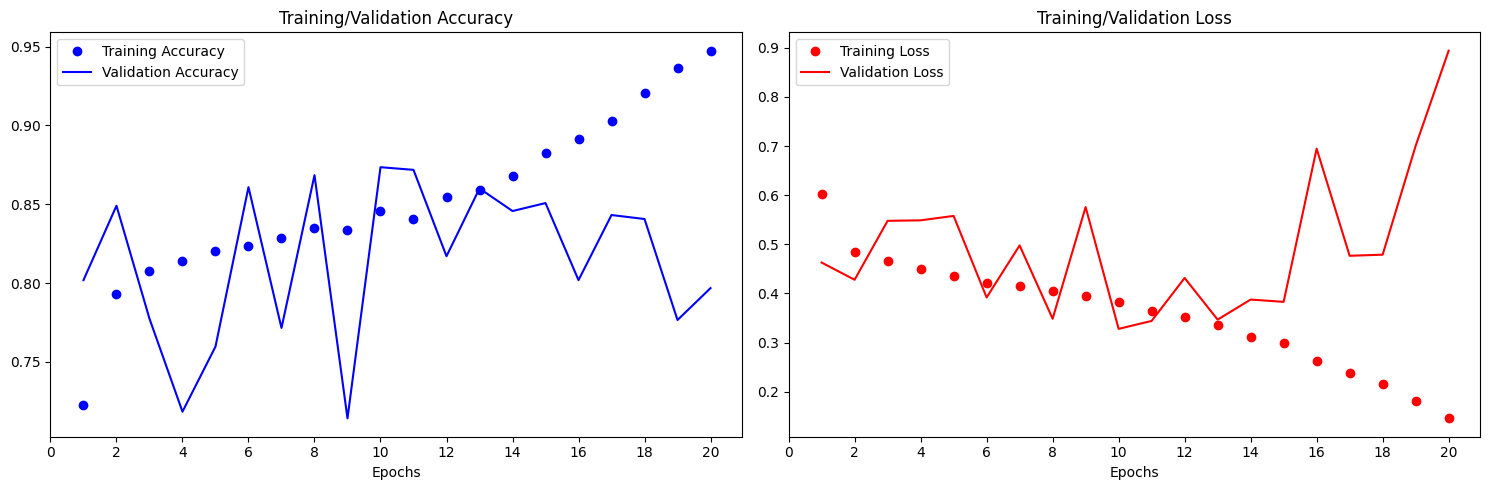

In [63]:
fig, axes = plt.subplots (nrows = 1, ncols = 2, figsize = (15,5))

axes[0].plot (epochs, accuracy, 'bo', label = 'Training Accuracy')
axes[0].plot (epochs, val_acc, 'b', label = 'Validation Accuracy')
axes[0].set_title ('Training/Validation Accuracy')
axes[0].set_xlabel ('Epochs')
axes[0].set_xticks (range(0, len(accuracy)+1, 2))
axes[0].legend()


axes[1].plot (epochs, loss, 'bo', color = 'red', label = 'Training Loss')
axes[1].plot (epochs, val_loss, 'b', color= 'red', label = 'Validation Loss')
axes[1].set_title ('Training/Validation Loss')
axes[1].set_xlabel('Epochs')
axes[1].set_xticks (range(0, len(accuracy)+1, 2))
axes[1].legend()

plt.tight_layout()
plt.show()

In [64]:
base_model.save('models/baseline_model.h5')